In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, BatchNormalization, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model
from itertools import product
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
import seqdata

tf.keras.utils.set_random_seed(0)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

2023-04-12 11:15:54.769667: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 11:15:54.987656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 11:15:54.989288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 11:15:55.960224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Plot model
#
# tf.keras.utils.plot_model(
#     model,
#     to_file='model.png',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False
# )

## One-hot encoding

In [2]:
train_data = seqdata.Seq('train/', 'ohe')
test_data = seqdata.Seq('test/', 'ohe')

max_len = seqdata.pad_data(train_data, test_data)

train_data.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], True)
test_data.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], False)

In [3]:
feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

dense1 = Dense(128, activation='relu')(feat_extraction_out)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout2)

model = Model(inputs=feat_extraction_input, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 426)]             0         
                                                                 
 flatten (Flatten)           (None, 426)               0         
                                                                 
 dense (Dense)               (None, 128)               54656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 55,688
Trainable params: 55,688
Non-trainable params: 0
_________________________________________________________________


2023-04-05 21:10:37.587472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 21:10:37.591479: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.features, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 1s 10ms/step - loss: 1.1853 - Precision: 0.7665 - val_loss: 2.1871 - val_Precision: 0.0649 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 0s 6ms/step - loss: 0.6458 - Precision: 0.8688 - val_loss: 1.4510 - val_Precision: 0.5577 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 0s 5ms/step - loss: 0.5206 - Precision: 0.8897 - val_loss: 1.1945 - val_Precision: 0.7192 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 1s 9ms/step - loss: 0.4565 - Precision: 0.9022 - val_loss: 1.0285 - val_Precision: 0.7805 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 0s 5ms/step - loss: 0.4092 - Precision: 0.9051 - val_loss: 1.1903 - val_Precision: 0.7110 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 0s 4ms/step - loss: 0.3753 - Precision: 0.9071 - val_loss: 0.8465 - val_Precision: 0.8474 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 0s 4ms/step - los

In [5]:
# Model prediction
model_pred = model.predict(test_data.features)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 0s 1ms/step


,precision,recall,f1-score,support
snoRNA,0.487179,0.542857,0.513514,35.000000
rRNA,0.950704,0.978261,0.964286,138.000000
snRNA,0.476190,0.454545,0.465116,22.000000
mRNA,0.988889,0.956989,0.972678,186.000000
pre_miRNA,0.590909,0.780000,0.672414,50.000000
miRNA,0.447368,0.326923,0.377778,52.000000
tRNA,0.936170,0.988764,0.961749,89.000000
tmRNA,0.983871,0.871429,0.924242,70.000000
accuracy,0.852025,0.852025,0.852025,0.852025
macro avg,0.732660,0.737471,0.731472,642.000000


### CNN

In [24]:
# Input layer
input_layer = Input(shape=(max_len, 4))

# CNN layers
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
flatten1 = Flatten()(dropout2)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten1)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3339, 4)]         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 3337, 128)         1664      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 1668, 128)        0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 1668, 128)         0         
                                                                 
 conv1d_23 (Conv1D)          (None, 1666, 128)         49280     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 833, 128)         0         
 g1D)                                                     

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.seqs, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 38s 559ms/step - loss: 1.3314 - Precision: 0.6577 - val_loss: 2.2120 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 36s 542ms/step - loss: 0.8846 - Precision: 0.7963 - val_loss: 1.4911 - val_Precision: 0.5068 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 36s 550ms/step - loss: 0.6241 - Precision: 0.8621 - val_loss: 1.1785 - val_Precision: 0.8136 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 36s 551ms/step - loss: 0.5240 - Precision: 0.8817 - val_loss: 1.4583 - val_Precision: 0.6927 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 37s 556ms/step - loss: 0.4020 - Precision: 0.8981 - val_loss: 1.3481 - val_Precision: 0.7558 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.3689 - Precision: 0.9039
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [===========================

In [26]:
# Model prediction
model_pred = model.predict(test_data.seqs)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 3s 131ms/step


,precision,recall,f1-score,support
snoRNA,0.523810,0.628571,0.571429,35.000000
rRNA,0.902098,0.934783,0.918149,138.000000
snRNA,0.562500,0.409091,0.473684,22.000000
mRNA,0.925532,0.935484,0.930481,186.000000
pre_miRNA,0.770833,0.740000,0.755102,50.000000
miRNA,0.517857,0.557692,0.537037,52.000000
tRNA,0.966292,0.966292,0.966292,89.000000
tmRNA,1.000000,0.857143,0.923077,70.000000
accuracy,0.850467,0.850467,0.850467,0.850467
macro avg,0.771115,0.753632,0.759406,642.000000


### CNN + BiLSTM

In [3]:
# Input layer
input_layer = Input(shape=(max_len, 4))

# CNN layers
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)

lstm1 = Bidirectional(LSTM(128))(dropout2)

dense1 = Dense(128, activation='relu')(lstm1)
dropout4 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout4)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

2023-04-03 22:11:50.913563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 22:11:50.915197: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3339, 4)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3337, 128)         1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1668, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1668, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1666, 128)         49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 833, 128)         0         
 1D)                                                         

In [4]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.seqs, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 207s 3s/step - loss: 1.7826 - Precision: 0.4855 - val_loss: 5.0290 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 208s 3s/step - loss: 1.2750 - Precision: 0.5337 - val_loss: 3.1792 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 205s 3s/step - loss: 1.1158 - Precision: 0.5943 - val_loss: 2.9320 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 211s 3s/step - loss: 0.9474 - Precision: 0.7170 - val_loss: 3.3715 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 227s 3s/step - loss: 0.8697 - Precision: 0.7445 - val_loss: 2.8726 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 191s 3s/step - loss: 0.7774 - Precision: 0.7844 - val_loss: 2.8523 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 7/10
66/66 [======================

In [5]:
# Model prediction
model_pred = model.predict(test_data.seqs)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 18s 831ms/step


,precision,recall,f1-score,support
snoRNA,0.558824,0.542857,0.550725,35.000000
rRNA,0.869565,0.869565,0.869565,138.000000
snRNA,0.478261,0.500000,0.488889,22.000000
mRNA,0.778761,0.946237,0.854369,186.000000
pre_miRNA,0.581081,0.860000,0.693548,50.000000
miRNA,0.400000,0.230769,0.292683,52.000000
tRNA,0.988506,0.966292,0.977273,89.000000
tmRNA,1.000000,0.428571,0.600000,70.000000
accuracy,0.774143,0.774143,0.774143,0.774143
macro avg,0.706875,0.668036,0.665881,642.000000


### CNN + Features

In [6]:
input_layer = Input(shape=(max_len, 4))

conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
cnn_out = Flatten()(dropout2)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout2)

model = Model(inputs=[input_layer, feat_extraction_input], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3339, 4)]    0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 3337, 128)    1664        ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 1668, 128)   0           ['conv1d_4[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 1668, 128)    0           ['max_pooling1d_4[0][0]']        
                                                                                            

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data.seqs, train_data.features], train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 47s 696ms/step - loss: 0.8575 - Precision: 0.8224 - val_loss: 1.5733 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 42s 637ms/step - loss: 0.4979 - Precision: 0.8808 - val_loss: 1.1218 - val_Precision: 0.6839 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 43s 646ms/step - loss: 0.3851 - Precision: 0.8959 - val_loss: 0.7966 - val_Precision: 0.8667 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 43s 652ms/step - loss: 0.3144 - Precision: 0.9182 - val_loss: 0.8815 - val_Precision: 0.8293 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 42s 636ms/step - loss: 0.2573 - Precision: 0.9281 - val_loss: 0.8602 - val_Precision: 0.8080 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.1933 - Precision: 0.9414
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [===========================

In [8]:
# Model prediction
model_pred = model.predict([test_data.seqs, test_data.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 3s 132ms/step


,precision,recall,f1-score,support
snoRNA,0.647059,0.628571,0.637681,35.00000
rRNA,0.937931,0.985507,0.961131,138.00000
snRNA,0.555556,0.454545,0.500000,22.00000
mRNA,0.967914,0.973118,0.970509,186.00000
pre_miRNA,0.755102,0.740000,0.747475,50.00000
miRNA,0.543860,0.596154,0.568807,52.00000
tRNA,0.967033,0.988764,0.977778,89.00000
tmRNA,1.000000,0.871429,0.931298,70.00000
accuracy,0.881620,0.881620,0.881620,0.88162
macro avg,0.796807,0.779761,0.786835,642.00000


### CNN + BiLSTM + Features

In [3]:
input_layer = Input(shape=(max_len, 4))

conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)

lstm1 = Bidirectional(LSTM(128))(dropout2)
cnn_out = Flatten()(lstm1)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout2)

model = Model(inputs=[input_layer, feat_extraction_input], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

2023-04-03 23:10:05.713715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 23:10:05.715791: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3339, 4)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 3337, 128)    1664        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1668, 128)    0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 1668, 128)    0           ['max_pooling1d[0][0]']          
                                                                                              

In [4]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data.seqs, train_data.features], train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 168s 2s/step - loss: 0.9785 - Precision: 0.8141 - val_loss: 2.0635 - val_Precision: 0.0278 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 177s 3s/step - loss: 0.5882 - Precision: 0.8771 - val_loss: 1.4211 - val_Precision: 0.4455 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 178s 3s/step - loss: 0.4821 - Precision: 0.8938 - val_loss: 1.0940 - val_Precision: 0.7310 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 174s 3s/step - loss: 0.4099 - Precision: 0.9024 - val_loss: 0.8101 - val_Precision: 0.8466 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 175s 3s/step - loss: 0.3659 - Precision: 0.9088 - val_loss: 0.6974 - val_Precision: 0.8798 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 180s 3s/step - loss: 0.3302 - Precision: 0.9149 - val_loss: 0.6286 - val_Precision: 0.9073 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 179s 3s/step

In [5]:
# Model prediction
model_pred = model.predict([test_data.seqs, test_data.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 15s 685ms/step


,precision,recall,f1-score,support
snoRNA,0.500000,0.485714,0.492754,35.000000
rRNA,0.943662,0.971014,0.957143,138.000000
snRNA,0.434783,0.454545,0.444444,22.000000
mRNA,0.994413,0.956989,0.975342,186.000000
pre_miRNA,0.600000,0.780000,0.678261,50.000000
miRNA,0.577778,0.500000,0.536082,52.000000
tRNA,0.967033,0.988764,0.977778,89.000000
tmRNA,1.000000,0.900000,0.947368,70.000000
accuracy,0.864486,0.864486,0.864486,0.864486
macro avg,0.752209,0.754628,0.751147,642.000000


## Label Encoding (Embedding Layer)

In [2]:
train_data = seqdata.Seq('train/', 'label')
test_data = seqdata.Seq('test/', 'label')

max_len = seqdata.pad_data(train_data, test_data)

train_data.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], True)
test_data.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], False)

### CNN

In [13]:
# Functional Model Keras

# cnn input

input_layer = Input(shape=(max_len,))

embedding1 = Embedding(5, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
flatten1 = Flatten()(dropout2)

dense1 = Dense(128, activation='relu')(flatten1)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3339)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 3339, 32)          160       
                                                                 
 conv1d_6 (Conv1D)           (None, 3337, 128)         12416     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1668, 128)        0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 1668, 128)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1666, 128)         49280     
                                                           

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.seqs, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 39s 581ms/step - loss: 1.4540 - Precision: 0.6084 - val_loss: 2.4258 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 38s 577ms/step - loss: 1.0811 - Precision: 0.7072 - val_loss: 2.3312 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 41s 618ms/step - loss: 0.8629 - Precision: 0.7778 - val_loss: 1.2071 - val_Precision: 0.8065 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 38s 581ms/step - loss: 0.6901 - Precision: 0.8385 - val_loss: 2.0086 - val_Precision: 0.6500 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 41s 624ms/step - loss: 0.5665 - Precision: 0.8527 - val_loss: 1.7273 - val_Precision: 0.7238 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.4979 - Precision: 0.8716
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [=======================

In [15]:
# Model prediction
model_pred = model.predict(test_data.seqs)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 3s 127ms/step


,precision,recall,f1-score,support
snoRNA,0.583333,0.600000,0.591549,35.000000
rRNA,0.923077,0.869565,0.895522,138.000000
snRNA,0.692308,0.409091,0.514286,22.000000
mRNA,0.877451,0.962366,0.917949,186.000000
pre_miRNA,0.639344,0.780000,0.702703,50.000000
miRNA,0.442308,0.442308,0.442308,52.000000
tRNA,0.966292,0.966292,0.966292,89.000000
tmRNA,1.000000,0.814286,0.897638,70.000000
accuracy,0.831776,0.831776,0.831776,0.831776
macro avg,0.765514,0.730488,0.741031,642.000000


### CNN + BiLSTM

In [16]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(5, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)

lstm1 = Bidirectional(LSTM(128))(dropout2)

dense1 = Dense(128, activation='relu')(lstm1)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3339)]            0         
                                                                 
 embedding_4 (Embedding)     (None, 3339, 32)          160       
                                                                 
 conv1d_8 (Conv1D)           (None, 3337, 128)         12416     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1668, 128)        0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 1668, 128)         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1666, 128)         49280     
                                                           

In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.seqs, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 169s 3s/step - loss: 1.8974 - Precision: 0.5263 - val_loss: 3.0197 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 163s 2s/step - loss: 1.8290 - Precision: 0.3243 - val_loss: 3.9601 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 205s 3s/step - loss: 1.3506 - Precision: 0.5272 - val_loss: 3.7718 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 1.1737 - Precision: 0.5908
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [==============================] - 160s 2s/step - loss: 1.1737 - Precision: 0.5908 - val_loss: 3.4150 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 185s 3s/step - loss: 1.0100 - Precision: 0.7021 - val_loss: 3.4264 - val_Precision: 0.0000e+00 - lr: 2.0000e-04
Epoch 6/10
66/66 [=================

In [18]:
# Model prediction
model_pred = model.predict(test_data.seqs)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 16s 736ms/step


/home/brenoslivio/miniconda3/envs/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brenoslivio/miniconda3/envs/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brenoslivio/miniconda3/envs/py/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

,precision,recall,f1-score,support
snoRNA,0.483871,0.428571,0.454545,35.000000
rRNA,0.468254,0.855072,0.605128,138.000000
snRNA,1.000000,0.045455,0.086957,22.000000
mRNA,0.732877,0.575269,0.644578,186.000000
pre_miRNA,0.516854,0.920000,0.661871,50.000000
miRNA,0.263158,0.096154,0.140845,52.000000
tRNA,0.817308,0.955056,0.880829,89.000000
tmRNA,0.000000,0.000000,0.000000,70.000000
accuracy,0.587227,0.587227,0.587227,0.587227
macro avg,0.535290,0.484447,0.434344,642.000000


### CNN + Features

In [19]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(5, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
cnn_out = Flatten()(dropout2)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=[input_layer, feat_extraction_input], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 3339)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 3339, 32)     160         ['input_6[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 3337, 128)    12416       ['embedding_5[0][0]']            
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 1668, 128)   0           ['conv1d_10[0][0]']              
 )                                                                                          

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data.seqs, train_data.features], train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 43s 636ms/step - loss: 0.8691 - Precision: 0.8413 - val_loss: 1.4598 - val_Precision: 0.5536 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 41s 615ms/step - loss: 0.4899 - Precision: 0.8940 - val_loss: 0.9836 - val_Precision: 0.7817 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 39s 596ms/step - loss: 0.3840 - Precision: 0.9057 - val_loss: 0.7946 - val_Precision: 0.8995 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 39s 585ms/step - loss: 0.3282 - Precision: 0.9123 - val_loss: 0.7012 - val_Precision: 0.8878 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 36s 537ms/step - loss: 0.2826 - Precision: 0.9257 - val_loss: 0.7050 - val_Precision: 0.8667 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 33s 504ms/step - loss: 0.2411 - Precision: 0.9268 - val_loss: 0.7134 - val_Precision: 0.8419 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 

In [21]:
# Model prediction
model_pred = model.predict([test_data.seqs, test_data.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 3s 136ms/step


,precision,recall,f1-score,support
snoRNA,0.585366,0.685714,0.631579,35.000000
rRNA,0.912162,0.978261,0.944056,138.000000
snRNA,0.500000,0.500000,0.500000,22.000000
mRNA,0.983240,0.946237,0.964384,186.000000
pre_miRNA,0.709091,0.780000,0.742857,50.000000
miRNA,0.586957,0.519231,0.551020,52.000000
tRNA,0.977778,0.988764,0.983240,89.000000
tmRNA,1.000000,0.871429,0.931298,70.000000
accuracy,0.873832,0.873832,0.873832,0.873832
macro avg,0.781824,0.783704,0.781054,642.000000


### CNN + BiLSTM + Features

In [24]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(5, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)

lstm1 = Bidirectional(LSTM(128))(dropout2)
cnn_out = Flatten()(lstm1)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=[input_layer, feat_extraction_input], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 3339)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 3339, 32)     160         ['input_10[0][0]']               
                                                                                                  
 conv1d_14 (Conv1D)             (None, 3337, 128)    12416       ['embedding_7[0][0]']            
                                                                                                  
 max_pooling1d_14 (MaxPooling1D  (None, 1668, 128)   0           ['conv1d_14[0][0]']              
 )                                                                                          

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data.seqs, train_data.features], train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 202s 3s/step - loss: 1.0378 - Precision: 0.7965 - val_loss: 1.6112 - val_Precision: 0.2101 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 197s 3s/step - loss: 0.5989 - Precision: 0.8673 - val_loss: 1.2273 - val_Precision: 0.6241 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 182s 3s/step - loss: 0.4750 - Precision: 0.8854 - val_loss: 0.9519 - val_Precision: 0.7816 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 197s 3s/step - loss: 0.4261 - Precision: 0.9035 - val_loss: 0.9026 - val_Precision: 0.8000 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 183s 3s/step - loss: 0.3981 - Precision: 0.9051 - val_loss: 0.9111 - val_Precision: 0.8032 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 180s 3s/step - loss: 0.3579 - Precision: 0.9051 - val_loss: 0.7575 - val_Precision: 0.8424 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 150s 2s/step

In [26]:
# Model prediction
model_pred = model.predict([test_data.seqs, test_data.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 14s 656ms/step


,precision,recall,f1-score,support
snoRNA,0.468750,0.428571,0.447761,35.000000
rRNA,0.912162,0.978261,0.944056,138.000000
snRNA,0.500000,0.590909,0.541667,22.000000
mRNA,0.983240,0.946237,0.964384,186.000000
pre_miRNA,0.620690,0.720000,0.666667,50.000000
miRNA,0.534884,0.442308,0.484211,52.000000
tRNA,0.956522,0.988764,0.972376,89.000000
tmRNA,1.000000,0.914286,0.955224,70.000000
accuracy,0.856698,0.856698,0.856698,0.856698
macro avg,0.747031,0.751167,0.747043,642.000000


## k-mer Encoding (Embedding layer)

In [2]:
train_data = seqdata.Seq('train/', 'k-mer')
test_data = seqdata.Seq('test/', 'k-mer')

max_len = seqdata.pad_data(train_data, test_data)

train_data.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], True)
test_data.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], False)

In [3]:
num_words = len([comb for comb in product(['A', 'C', 'G', 'T'], repeat= 6)])

### CNN

In [7]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(num_words, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
flatten1 = Flatten()(dropout2)

dense1 = Dense(128, activation='relu')(flatten1)
dropout2 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3334)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 3334, 32)          131072    
                                                                 
 conv1d_2 (Conv1D)           (None, 3332, 128)         12416     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1666, 128)        0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1666, 128)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1664, 128)         49280     
                                                           

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.seqs, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 39s 583ms/step - loss: 1.4131 - Precision: 0.6783 - val_loss: 2.3623 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 39s 596ms/step - loss: 0.9178 - Precision: 0.8134 - val_loss: 2.3458 - val_Precision: 0.1538 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 40s 600ms/step - loss: 0.6954 - Precision: 0.8598 - val_loss: 1.8572 - val_Precision: 0.3898 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 41s 618ms/step - loss: 0.5684 - Precision: 0.8651 - val_loss: 3.1041 - val_Precision: 0.3854 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 39s 593ms/step - loss: 0.4281 - Precision: 0.8966 - val_loss: 2.5119 - val_Precision: 0.6179 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.3309 - Precision: 0.9171
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [===========================

In [9]:
# Model prediction
model_pred = model.predict(test_data.seqs)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 3s 120ms/step


,precision,recall,f1-score,support
snoRNA,0.406250,0.371429,0.388060,35.000000
rRNA,0.880795,0.963768,0.920415,138.000000
snRNA,0.600000,0.272727,0.375000,22.000000
mRNA,0.941799,0.956989,0.949333,186.000000
pre_miRNA,0.636364,0.560000,0.595745,50.000000
miRNA,0.417910,0.538462,0.470588,52.000000
tRNA,0.936842,1.000000,0.967391,89.000000
tmRNA,1.000000,0.771429,0.870968,70.000000
accuracy,0.823988,0.823988,0.823988,0.823988
macro avg,0.727495,0.679350,0.692188,642.000000


### CNN + BiLSTM

In [11]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(num_words, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)

lstm1 = Bidirectional(LSTM(128))(dropout2)

dense1 = Dense(128, activation='relu')(lstm1)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3334)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 3334, 32)          131072    
                                                                 
 conv1d_6 (Conv1D)           (None, 3332, 128)         12416     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1666, 128)        0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 1666, 128)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1664, 128)         49280     
                                                           

In [12]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit(train_data.seqs, train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 183s 3s/step - loss: 1.7352 - Precision: 0.5355 - val_loss: 3.1446 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 154s 2s/step - loss: 1.0365 - Precision: 0.7897 - val_loss: 2.9726 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 201s 3s/step - loss: 0.7277 - Precision: 0.8749 - val_loss: 2.6866 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 169s 3s/step - loss: 0.5963 - Precision: 0.8624 - val_loss: 2.4997 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 180s 3s/step - loss: 0.5190 - Precision: 0.8651 - val_loss: 2.6886 - val_Precision: 0.0843 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 187s 3s/step - loss: 0.4148 - Precision: 0.8801 - val_loss: 1.9497 - val_Precision: 0.5865 - lr: 0.0010
Epoch 7/10
66/66 [==============================

In [13]:
# Model prediction
model_pred = model.predict(test_data.seqs)
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 18s 840ms/step


,precision,recall,f1-score,support
snoRNA,0.444444,0.571429,0.500000,35.000000
rRNA,0.955556,0.934783,0.945055,138.000000
snRNA,0.208333,0.227273,0.217391,22.000000
mRNA,0.820755,0.935484,0.874372,186.000000
pre_miRNA,0.625000,0.600000,0.612245,50.000000
miRNA,0.456522,0.403846,0.428571,52.000000
tRNA,0.913043,0.943820,0.928177,89.000000
tmRNA,0.950000,0.542857,0.690909,70.000000
accuracy,0.780374,0.780374,0.780374,0.780374
macro avg,0.671707,0.644936,0.649590,642.000000


### CNN + Features

In [14]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(num_words, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
cnn_out = Flatten()(dropout2)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=[input_layer, feat_extraction_input], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3334)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 3334, 32)     131072      ['input_5[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 3332, 128)    12416       ['embedding_4[0][0]']            
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 1666, 128)   0           ['conv1d_8[0][0]']               
                                                                                            

In [15]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data.seqs, train_data.features], train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 46s 674ms/step - loss: 0.8600 - Precision: 0.8447 - val_loss: 1.5996 - val_Precision: 0.0339 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 46s 696ms/step - loss: 0.4944 - Precision: 0.8792 - val_loss: 0.8084 - val_Precision: 0.8636 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 50s 754ms/step - loss: 0.3470 - Precision: 0.9033 - val_loss: 0.9262 - val_Precision: 0.7742 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 45s 686ms/step - loss: 0.2466 - Precision: 0.9311 - val_loss: 1.2798 - val_Precision: 0.6895 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - ETA: 0s - loss: 0.2049 - Precision: 0.9389
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [==============================] - 45s 678ms/step - loss: 0.2049 - Precision: 0.9389 - val_loss: 1.6496 - val_Precision: 0.6696 - lr: 0.0010
Epoch 6/10
66/66 [==============================]

In [16]:
# Model prediction
model_pred = model.predict([test_data.seqs, test_data.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 3s 146ms/step


,precision,recall,f1-score,support
snoRNA,0.562500,0.514286,0.537313,35.000000
rRNA,0.924138,0.971014,0.946996,138.000000
snRNA,0.600000,0.545455,0.571429,22.000000
mRNA,0.951613,0.951613,0.951613,186.000000
pre_miRNA,0.614035,0.700000,0.654206,50.000000
miRNA,0.571429,0.538462,0.554455,52.000000
tRNA,0.956522,0.988764,0.972376,89.000000
tmRNA,1.000000,0.871429,0.931298,70.000000
accuracy,0.861371,0.861371,0.861371,0.861371
macro avg,0.772530,0.760128,0.764961,642.000000


### CNN + BiLSTM + Features

In [4]:
input_layer = Input(shape=(max_len,))

embedding1 = Embedding(num_words, 32, input_length=max_len)(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)

lstm1 = Bidirectional(LSTM(128))(dropout2)
cnn_out = Flatten()(lstm1)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=[input_layer, feat_extraction_input], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

2023-04-04 15:25:22.845864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 15:25:22.850152: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3334)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 3334, 32)     131072      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 3332, 128)    12416       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1666, 128)    0           ['conv1d[0][0]']                 
                                                                                              

In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data.seqs, train_data.features], train_data.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 197s 3s/step - loss: 1.0495 - Precision: 0.8139 - val_loss: 1.8223 - val_Precision: 0.1574 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 181s 3s/step - loss: 0.5984 - Precision: 0.8666 - val_loss: 1.2929 - val_Precision: 0.5226 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 190s 3s/step - loss: 0.4534 - Precision: 0.8925 - val_loss: 1.1078 - val_Precision: 0.6667 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 169s 3s/step - loss: 0.3659 - Precision: 0.9118 - val_loss: 0.9332 - val_Precision: 0.7565 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 186s 3s/step - loss: 0.2787 - Precision: 0.9311 - val_loss: 0.7871 - val_Precision: 0.8450 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 195s 3s/step - loss: 0.2143 - Precision: 0.9552 - val_loss: 0.8845 - val_Precision: 0.7804 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 189s 3s/step

In [6]:
# Model prediction
model_pred = model.predict([test_data.seqs, test_data.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 19s 873ms/step


,precision,recall,f1-score,support
snoRNA,0.509091,0.800000,0.622222,35.000000
rRNA,0.944056,0.978261,0.960854,138.000000
snRNA,0.500000,0.454545,0.476190,22.000000
mRNA,0.988701,0.940860,0.964187,186.000000
pre_miRNA,0.600000,0.600000,0.600000,50.000000
miRNA,0.510638,0.461538,0.484848,52.000000
tRNA,1.000000,0.988764,0.994350,89.000000
tmRNA,0.983871,0.871429,0.924242,70.000000
accuracy,0.858255,0.858255,0.858255,0.858255
macro avg,0.754545,0.761925,0.753362,642.000000


## Encode merging

In [2]:
train_data1 = seqdata.Seq('train/', 'ohe')
test_data1 = seqdata.Seq('test/', 'ohe')
max_len1 = seqdata.pad_data(train_data1, test_data1)

train_data2 = seqdata.Seq('train/', 'label')
test_data2 = seqdata.Seq('test/', 'label')
max_len2 = seqdata.pad_data(train_data2, test_data2)

train_data3 = seqdata.Seq('train/', 'k-mer')
test_data3 = seqdata.Seq('test/', 'k-mer')
max_len3 = seqdata.pad_data(train_data3, test_data3)

num_words = len([comb for comb in product(['A', 'C', 'G', 'T'], repeat= 6)])

train_data1.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], True)
test_data1.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], False)

In [3]:
# one-hot encoding input layer
input_layer1 = Input(shape=(max_len1, 4))

conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
ohe_out = Flatten()(dropout2)

# label encoding input layer
input_layer2 = Input(shape=(max_len2,))

embedding1 = Embedding(5, 32, input_length=max_len2)(input_layer2)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
label_out = Flatten()(dropout2)

# k-mer input layer
input_layer3 = Input(shape=(max_len3,))

embedding1 = Embedding(num_words, 32, input_length=max_len3)(input_layer3)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
kmer_out = Flatten()(dropout2)

concat = Concatenate()([ohe_out, label_out, kmer_out])

dense1 = Dense(128, activation='relu')(concat)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

2023-04-04 13:50:18.728062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:50:18.731021: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3339)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3334)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 3339, 4)]    0           []                               
                                                                                                  
 embedding (Embedding)          (None, 3339, 32)     160         ['input_2[0][0]']                
                                                                                              

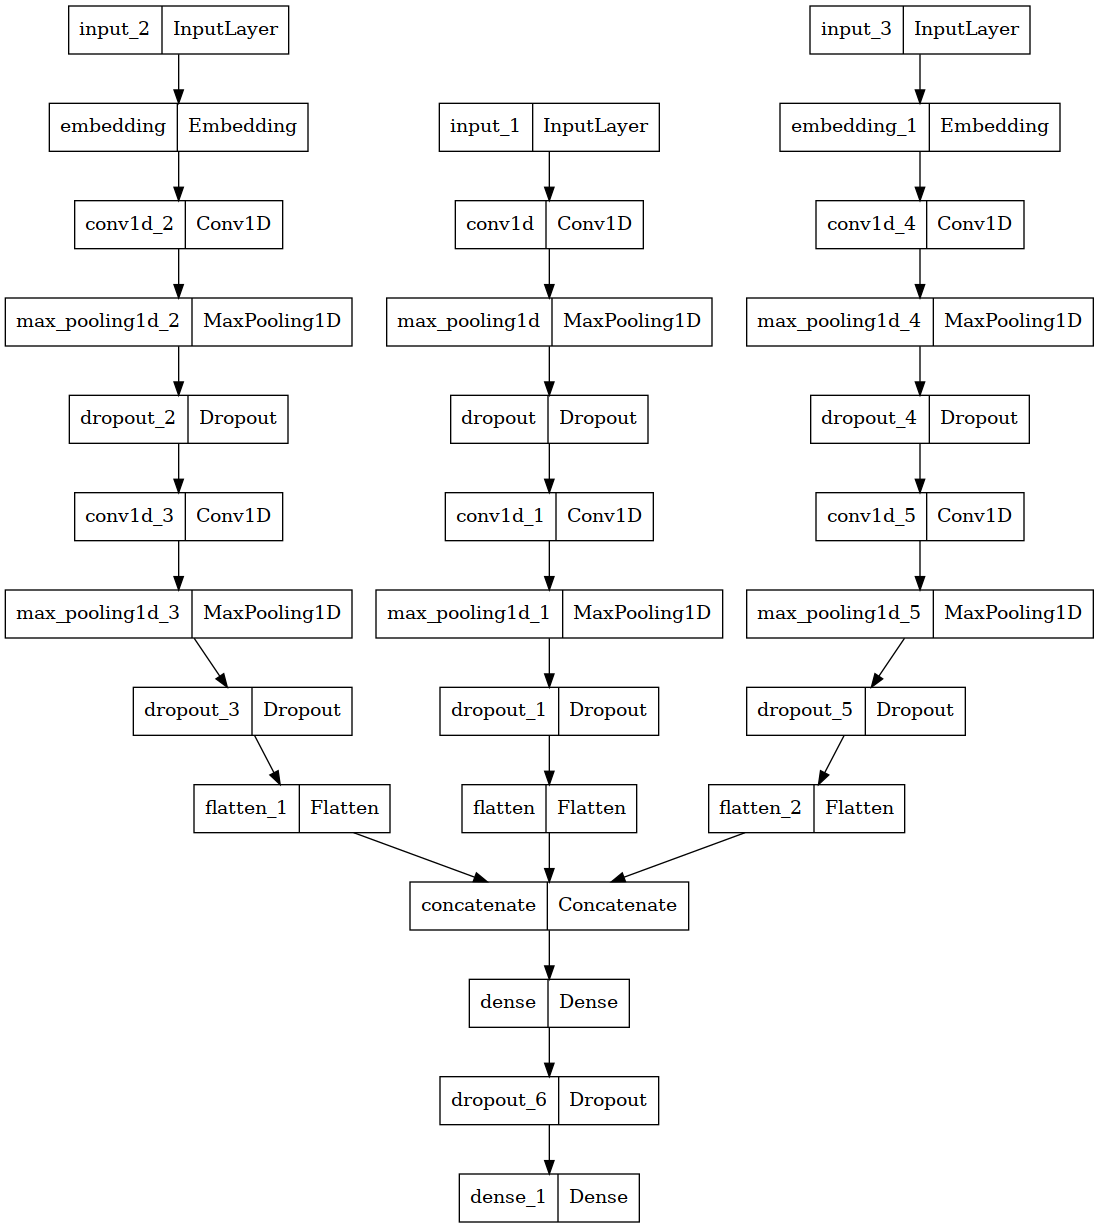

In [4]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [5]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data1.seqs, train_data2.seqs, train_data3.seqs], train_data1.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 124s 2s/step - loss: 1.3759 - Precision: 0.6547 - val_loss: 1.8695 - val_Precision: 0.0000e+00 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 131s 2s/step - loss: 0.8181 - Precision: 0.8088 - val_loss: 2.1946 - val_Precision: 0.3989 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 130s 2s/step - loss: 0.5233 - Precision: 0.8782 - val_loss: 1.3262 - val_Precision: 0.8047 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 136s 2s/step - loss: 0.4111 - Precision: 0.9008 - val_loss: 1.4734 - val_Precision: 0.7860 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 142s 2s/step - loss: 0.3098 - Precision: 0.9130 - val_loss: 1.9705 - val_Precision: 0.7455 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.2395 - Precision: 0.9241
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [==============================] - 133

In [6]:
# Model prediction
model_pred = model.predict([test_data1.seqs, test_data2.seqs, test_data3.seqs])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data1.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data1.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 7s 326ms/step


,precision,recall,f1-score,support
snoRNA,0.600000,0.685714,0.640000,35.000000
rRNA,0.862069,0.905797,0.883392,138.000000
snRNA,0.625000,0.454545,0.526316,22.000000
mRNA,0.895288,0.919355,0.907162,186.000000
pre_miRNA,0.660000,0.660000,0.660000,50.000000
miRNA,0.562500,0.519231,0.540000,52.000000
tRNA,0.945652,0.977528,0.961326,89.000000
tmRNA,1.000000,0.857143,0.923077,70.000000
accuracy,0.836449,0.836449,0.836449,0.836449
macro avg,0.768814,0.747414,0.755159,642.000000


### Merged encoding + features

In [10]:
# one-hot encoding input layer
input_layer1 = Input(shape=(max_len1, 4))

conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(input_layer1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
ohe_out = Flatten()(dropout2)

# label encoding input layer
input_layer2 = Input(shape=(max_len2,))

embedding1 = Embedding(5, 32, input_length=max_len2)(input_layer2)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
label_out = Flatten()(dropout2)

# k-mer input layer
input_layer3 = Input(shape=(max_len3,))

embedding1 = Embedding(num_words, 32, input_length=max_len3)(input_layer3)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding1)
max_pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(max_pool1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
max_pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(max_pool2)
kmer_out = Flatten()(dropout2)

# feature extraction input layer
input_layer4 = Input(shape=(426,))
feat_extraction_out = Flatten()(input_layer4)

concat = Concatenate()([ohe_out, label_out, kmer_out, feat_extraction_out])

dense1 = Dense(128, activation='relu')(concat)
dropout3 = Dropout(0.5)(dense1)
output_layer = Dense(8, activation='softmax')(dropout3)

model = Model(inputs=[input_layer1, input_layer2, input_layer3, input_layer4], outputs=output_layer)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(name="Precision")])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3339)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 3334)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 3339, 4)]    0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 3339, 32)     160         ['input_9[0][0]']                
                                                                                            

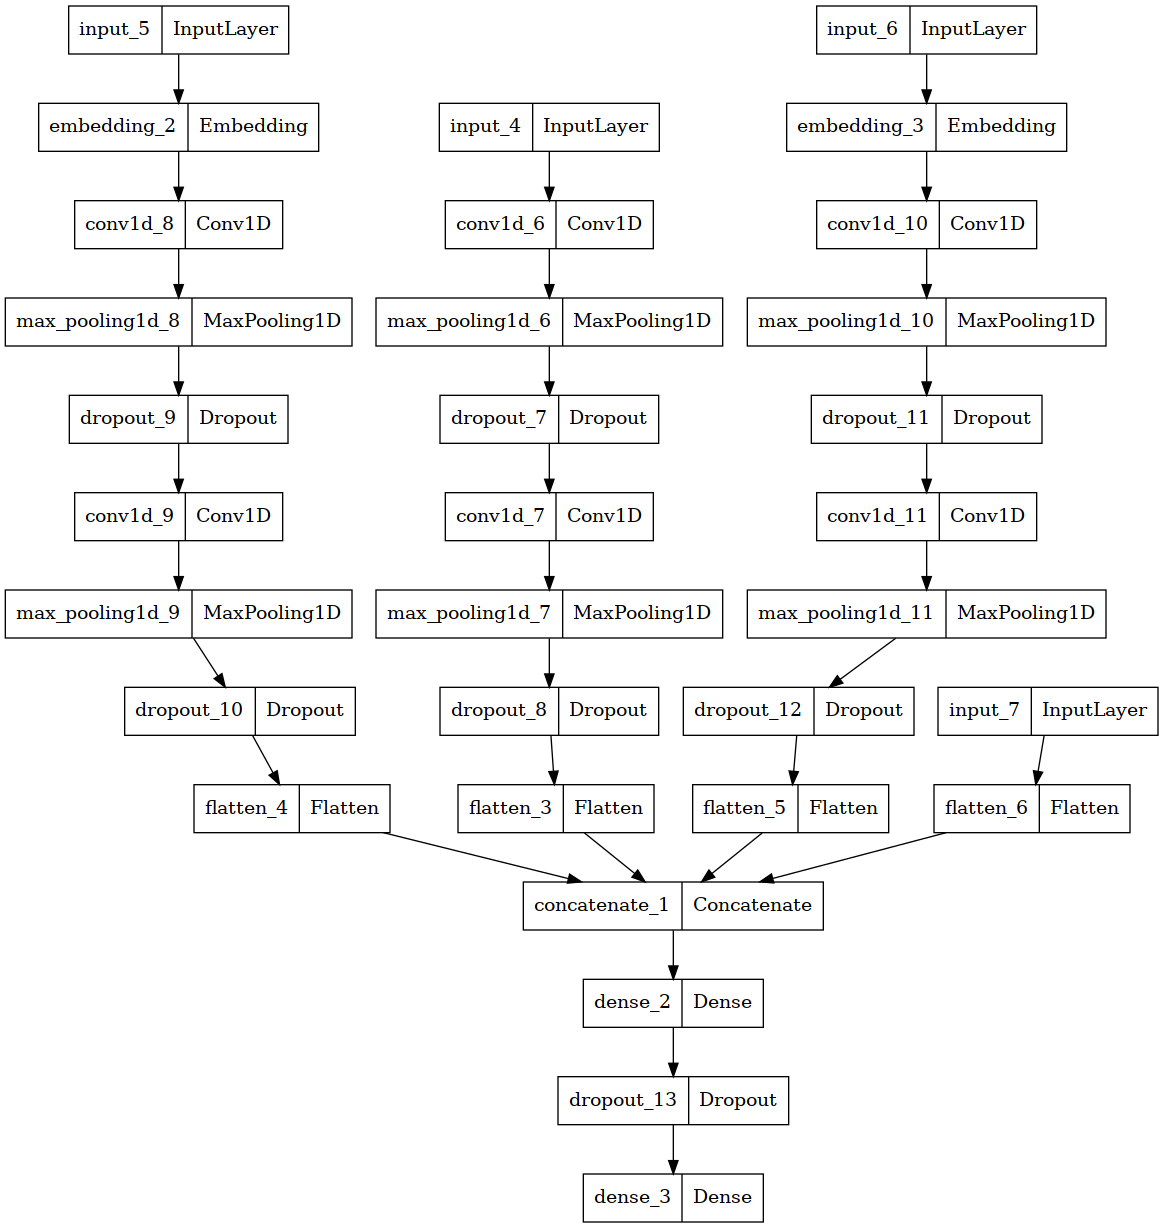

In [8]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

model.fit([train_data1.seqs, train_data2.seqs, train_data3.seqs, train_data1.features], train_data1.labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
66/66 [==============================] - 119s 2s/step - loss: 0.9464 - Precision: 0.8334 - val_loss: 1.3872 - val_Precision: 0.5750 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 122s 2s/step - loss: 0.4886 - Precision: 0.8877 - val_loss: 0.8527 - val_Precision: 0.7868 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 110s 2s/step - loss: 0.3744 - Precision: 0.9116 - val_loss: 0.7423 - val_Precision: 0.8713 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 114s 2s/step - loss: 0.2883 - Precision: 0.9189 - val_loss: 0.8556 - val_Precision: 0.8056 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 114s 2s/step - loss: 0.2138 - Precision: 0.9359 - val_loss: 1.4454 - val_Precision: 0.7018 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - ETA: 0s - loss: 0.1626 - Precision: 0.9586
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
66/66 [==============================] - 114s 2s

In [12]:
# Model prediction
model_pred = model.predict([test_data1.seqs, test_data2.seqs, test_data3.seqs, test_data1.features])
y_pred = np.argmax(model_pred, axis=1)
y_true = np.argmax(test_data1.labels, axis=1)

# Classification report
report = classification_report(y_true, y_pred, target_names=test_data1.names, output_dict=True)
pd.DataFrame(report).T

21/21 [==============================] - 6s 276ms/step


,precision,recall,f1-score,support
snoRNA,0.606061,0.571429,0.588235,35.00000
rRNA,0.937063,0.971014,0.953737,138.00000
snRNA,0.520000,0.590909,0.553191,22.00000
mRNA,0.972973,0.967742,0.970350,186.00000
pre_miRNA,0.734694,0.720000,0.727273,50.00000
miRNA,0.578947,0.634615,0.605505,52.00000
tRNA,1.000000,1.000000,1.000000,89.00000
tmRNA,1.000000,0.871429,0.931298,70.00000
accuracy,0.881620,0.881620,0.881620,0.88162
macro avg,0.793717,0.790892,0.791199,642.00000
